In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [3]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [5]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))
dk

0.01269330365086785

In [6]:
eta = np.transpose(wamos, (1, 2, 0))
eta.shape

(132, 132, 366)

In [7]:
Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0] 

Norm = dKx * dKy * dW

# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [8]:
def plot_3d_as_2d(x, y, z, radial_filter=False, extent=None, ax=None, aspect='auto', colorbar=True, cb_label='', data_min=None, data_max=None, cmap='viridis'):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    if radial_filter:
        filt = get_radial_filter(x, y)
    else:
        filt = 1
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    sh = ax.imshow((filt*z).T, origin='lower', extent=(x[0]-dx//2, x[-1]+dx//2, y[0]-dy//2, y[-1]+dy//2 ), aspect=aspect, interpolation=None, vmin=data_min, vmax=data_max, cmap=cmap)
    if colorbar:
        bar = plt.colorbar(sh, ax=ax, label=cb_label)
    if not extent is None:
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
    return ax

In [9]:
def plot_kx_ky_spec(kx, ky, spec, radial_filter=False, extent=None, ax=None, colorbar=True, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plot_3d_as_2d(kx, ky, spec, radial_filter, extent, ax, aspect=1, colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
    return ax

In [10]:
def plot_w_slice(at_w, extent, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-ky-spectrum and the integrated k-omega-spectrum
        '''
        if at_w > 0:
            i = np.argmin(np.abs(w[Nt//2:]-at_w))
            print(at_w, w[Nt//2+i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)
        else:
            i = np.argmin(np.abs(w[:Nt//2]-at_w))
            print(at_w, w[i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)

In [31]:
at_w = 0.8
i = np.argmin(np.abs(w[Nt//2:]-at_w))

In [32]:
# Flatten the array and get the indices of the sorted values
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]

# Take the top 20 indices
top_20_indices = flat_indices[:50]

# Convert flat indices to 2D indices
top_20_indices_2d = np.unravel_index(top_20_indices, power_Spectrum[:,:,Nt//2+i].shape)

kx_ind, ky_ind = top_20_indices_2d[0], top_20_indices_2d[1]

0.8 0.8006578727045026 115


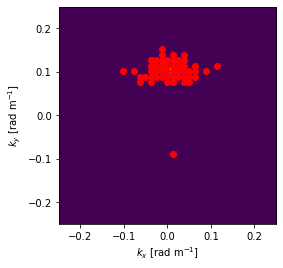

In [33]:
plot_w_slice(at_w, extent = [-0.25,0.25, -0.25, 0.25], ax=None, dB=None, vmin=None, save=False)

plt.scatter(Kx[kx_ind], Ky[ky_ind], color = 'red')

In [210]:
def felip(x, a, b):
    return np.sqrt(b**2 * (1-x**2/b**2))

In [320]:
def fit_elipse(at_w):
    '''Slices the Spectrum at_w and then fits an ellise to the points

    Input : at_w  location of the omgea slice (positive)
    
    Output : x_values  ellipse fitting x vals
             y_values  ellipse fitting y vals'''
    
    ## Find the rough Triplet value points 
    i = np.argmin(np.abs(w[Nt//2:]-at_w))
    flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
    top_indices = flat_indices[:50] # Take the top 20 indices
    top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
    kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
    triplet_x = Kx[kx_ind]
    triplet_y = Ky[ky_ind]
    
    ### Perform Elipse fitting ###
    
    # Curve fit when there's less than 5 negative ky values (ie not a circle)
    cond = (triplet_y < 0)
    if len(triplet_y[cond]) < 5:
        
        # perform fitting
        pars0 = (0.2, 0.2)
        ind = (triplet_y > 0)
        popt, pcov = curve_fit(felip, triplet_x[ind], triplet_y[ind], absolute_sigma=True, p0=pars0)

        # extract best-fit parameter and its error
        a_opt = popt[0]
        b_opt = popt[1]

        # creating x interval to include in y fit
        x = np.linspace(-0.2, 0.2, 100)
        y_fit = felip(x, *popt)
        
        # Find the indices two minimum values of y_fit
        min_indices = np.argsort(y_fit)[:2]

        ellipse_x = x[np.min(min_indices):np.max(min_indices)+1]
        ellipse_y = y_fit[np.min(min_indices):np.max(min_indices)+1]
        
        return ellipse_x, ellipse_y
    
    else:
        
        x = triplet_x
        y = triplet_y

        A = np.stack([x**2, x * y, y**2, x, y]).T
        b = np.ones_like(x)
        L = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

        xlin = np.linspace(-0.3, 0.3, 50)
        ylin = np.linspace(-0.3, 0.3, 50)
        X, Y = np.meshgrid(xlin, ylin)

        Z = L[0]*X**2 + L[1]*X*Y + L[2]*Y**2 + L[3]*X + L[4]*Y
        
        # Coordinates on the fitted curve
        contour_levels = [1]
        contour_lines = plt.contour(X, Y, Z, contour_levels, colors='red')
        contour_points = contour_lines.collections[0].get_paths()[0]
        coordinates_on_curve = contour_points.vertices
        
        plt.close()

        # Fitted curve full ellipse
        ellipse_x_full = coordinates_on_curve[:, 0]
        ellipse_y_full = coordinates_on_curve[:, 1]
        
        cond1 = (ellipse_y_full > 0)
        ellipse_x = ellipse_x_full[cond1]
        ellipse_y = ellipse_y_full[cond1]

        
        return ellipse_x, ellipse_y

In [307]:
def felip(x, a, b):
    return np.sqrt(np.abs(b**2 * (1-(x**2)/(b**2))))

In [308]:
at_w = 1.2

In [309]:
## Find the rough Triplet value points 
i = np.argmin(np.abs(w[Nt//2:]-at_w))
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
top_indices = flat_indices[:50] # Take the top 50 indices
top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
triplet_x = Kx[kx_ind]
triplet_y = Ky[ky_ind]

In [310]:
# Perform Elipse fitting
cond = (triplet_y < 0)

if len(triplet_y[cond]) < 5:
    print("perform yoke")

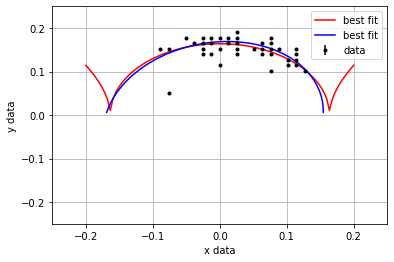

In [324]:
# perform fitting
pars0 = (0.2, 0.2)

ind = (triplet_y > 0)

popt, pcov = curve_fit(felip, triplet_x[ind], triplet_y[ind], absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
b_opt = popt[1]

# plot data
plt.errorbar(triplet_x[ind], triplet_y[ind], yerr=0, fmt=".", color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-0.2, 0.2, 100)
y_fit = felip(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")

#plt.plot(x[min_indices[0]:min_indices[1]+1], y_fit[min_indices[0]:min_indices[1]+1], color="blue", label="best fit")


plt.plot(x8, y8, color="blue", label="best fit")


plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.legend();

In [312]:
# Find the indices corresponding to the two minimum values of y_fit
min_indices = np.argsort(y_fit)[:2]

# Extract the corresponding x and y_fit values
#x_min_neg = x[]

In [313]:
min_indices

array([90,  9], dtype=int64)

(-0.25, 0.25)

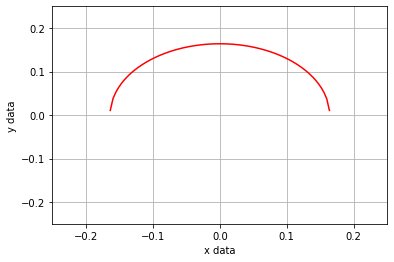

In [314]:
plt.plot(x[np.min(min_indices):np.max(min_indices)+1], y_fit[np.min(min_indices):np.max(min_indices)+1], color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")


plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

1.2 1.1975056878710821 172


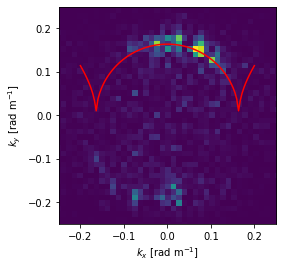

In [315]:
plot_w_slice(at_w, extent = [-0.25,0.25, -0.25, 0.25], ax=None, dB=None, vmin=None, save=False)

plt.plot(x, y_fit, color="red", label="best fit")

In [321]:
x8, y8 = fit_elipse(at_w)

In [322]:
fit_elipse(at_w)

(array([-0.16902373, -0.16608926, -0.16530612, -0.1622654 , -0.15768331,
        -0.15306122, -0.15237028, -0.14595773, -0.14081633, -0.1386826 ,
        -0.13022562, -0.12857143, -0.12035019, -0.11632653, -0.10888262,
        -0.10408163, -0.0953273 , -0.09183673, -0.07959184, -0.07886399,
        -0.06734694, -0.05716937, -0.05510204, -0.04285714, -0.03061224,
        -0.02212471, -0.01836735, -0.00612245,  0.00612245,  0.01836735,
         0.03061224,  0.04285714,  0.04401971,  0.05510204,  0.06734694,
         0.07591257,  0.07959184,  0.09183673,  0.09479039,  0.10408163,
         0.10855704,  0.11632653,  0.11938088,  0.1281418 ,  0.12857143,
         0.13504399,  0.14081633,  0.14086508,  0.14528549,  0.14882001,
         0.15149331,  0.15306122,  0.15330911,  0.1542548 ,  0.15446755]),
 array([0.00612245, 0.01836735, 0.02101309, 0.03061224, 0.04285714,
        0.05360683, 0.05510204, 0.06734694, 0.07619257, 0.07959184,
        0.09183673, 0.09403247, 0.10408163, 0.10863185, 0.1

In [323]:
y8

array([0.00612245, 0.01836735, 0.02101309, 0.03061224, 0.04285714,
       0.05360683, 0.05510204, 0.06734694, 0.07619257, 0.07959184,
       0.09183673, 0.09403247, 0.10408163, 0.10863185, 0.11632653,
       0.12094372, 0.12857143, 0.1314148 , 0.1403493 , 0.14081633,
       0.14774998, 0.15306122, 0.15407734, 0.15911113, 0.16318049,
       0.16530612, 0.16619444, 0.16811118, 0.16904088, 0.16895513,
       0.16782438, 0.16561797, 0.16530612, 0.16208085, 0.15728907,
       0.15306122, 0.15107463, 0.14308211, 0.14081633, 0.13294036,
       0.12857143, 0.12009675, 0.11632653, 0.10408163, 0.10339363,
       0.09183673, 0.07970487, 0.07959184, 0.06734694, 0.05510204,
       0.04285714, 0.03241341, 0.03061224, 0.01836735, 0.00612245])